In [1]:
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
        
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import mlflow
from mlflow.models import infer_signature
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
import shap

In [2]:
df = pd.read_csv("dataframe_final.csv")

In [3]:
# To start the mlflow server in local : mlflow server --host 127.0.0.1 --port 8080

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("OCR_Project7")

<Experiment: artifact_location='mlflow-artifacts:/660074711239750018', creation_time=1706799735679, experiment_id='660074711239750018', last_update_time=1706799735679, lifecycle_stage='active', name='OCR_Project7', tags={}>

In [4]:
def custom_score_func(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    FN = cf_matrix[1,0]
    FP = cf_matrix[0,1]

    return (10*FN+FP)/y.shape[0]

In [5]:
custom_scorer = make_scorer(custom_score_func, greater_is_better=False)

In [6]:
scoring = {"AUC": "roc_auc", "CustomScorer": custom_scorer}

In [7]:
def calcul_metrics(model, X, y):
    """Fonction de calcul des metriques précision, AUC et score_metier en fonction du modèle en entrée. Retourne un dictionnaire."""
    metrics = {}
    
    accuracy = model.score(X, y)
    print(f'Précision : {accuracy:.2f}')
    metrics['accuracy'] = accuracy
    
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    print(f'AUC : {roc_auc:.2f}')
    metrics['roc_auc'] = roc_auc

    score_metier = custom_score_func(y, model.predict(X))
    print(f'Score métier : {score_metier}')
    metrics['score_metier'] = score_metier

    return metrics
    

In [8]:
def logToMLflow(model, X, eval_data, metrics, name="", params="", training_tag=""):
    # Start an MLflow run
    with mlflow.start_run(run_name=name):
        # Log the hyperparameters
        if params:
            mlflow.log_params(params)

        # Log the loss metric
        mlflow.log_metric("accuracy", metrics['accuracy'])
        mlflow.log_metric("roc_auc", metrics['roc_auc'])
        mlflow.log_metric("score_metier", metrics['score_metier'])
    
        # Set a tag that we can use to remind ourselves what this run was for
        if training_tag:
            mlflow.set_tag("Training Info", training_tag)
    
        # Infer the model signature
        signature = infer_signature(X, model.predict(X))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(model, 'model', signature=signature)

        result = mlflow.evaluate(
            model_info.model_uri,
            eval_data,
            targets="TARGET",
            model_type="classifier",
            evaluators=["default"],
        )

In [9]:
def displayConfMatrix(model, valid_x, valid_y):
    plt.figure(figsize=(12,6))
    cf_matrix = confusion_matrix(valid_y, model.predict(valid_x))
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
      
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.show()

In [10]:
#Fonction d'affichage des résultats d'un GridSearch.

def resultizeGrid(grid):
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols]
    res = res.sort_values('rank_test_CustomScorer')
    
    return res

On divise notre dataframe en train et test en fonction de la présence de l'information dans 'TARGET'.

In [11]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print(f'train_df shape : {train_df.shape}')
print(f'test_df shape : {test_df.shape}')

train_df shape : (307507, 797)
test_df shape : (48744, 797)


In [12]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR']]

train_x, valid_x, train_y, valid_y = train_test_split(train_df[feats], train_df['TARGET'], test_size=0.15, random_state=0)

In [13]:
col = train_x.columns

train_x.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_x.replace([np.inf, -np.inf], np.nan, inplace=True)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_x = imp.fit_transform(train_x)
valid_x = imp.fit_transform(valid_x)

train_x = pd.DataFrame(train_x, columns=col)
valid_x = pd.DataFrame(valid_x, columns=col)

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)

In [14]:
train_x_30k = train_x[:30000]
train_y_30k = train_y[:30000]

In [15]:
train_x_10k = train_x[:10000]
train_y_10k = train_y[:10000]

In [16]:
test_feats = [f for f in test_df.columns if f not in ['TARGET']]

test_x = test_df[test_feats]
col = test_x.columns

test_x.replace([np.inf, -np.inf], np.nan, inplace=True)
test_x = imp.fit_transform(test_x)
test_x = pd.DataFrame(test_x, columns=col)

#test_x.to_csv("dataframe_final_test.csv", index=False)

# LOGISTIC REGRESSION

## Without SMOTE

Gestion des valeurs manquantes.

Précision : 0.92
AUC : 0.53
Score métier : 0.7968434973009301
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42452
         1.0       0.08      0.00      0.00      3675

    accuracy                           0.92     46127
   macro avg       0.50      0.50      0.48     46127
weighted avg       0.85      0.92      0.88     46127



2024/02/09 15:12:13 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/09 15:12:13 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/09 15:12:17 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Linear is used.
2024/02/09 15:12:17 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'LogisticRegression' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.


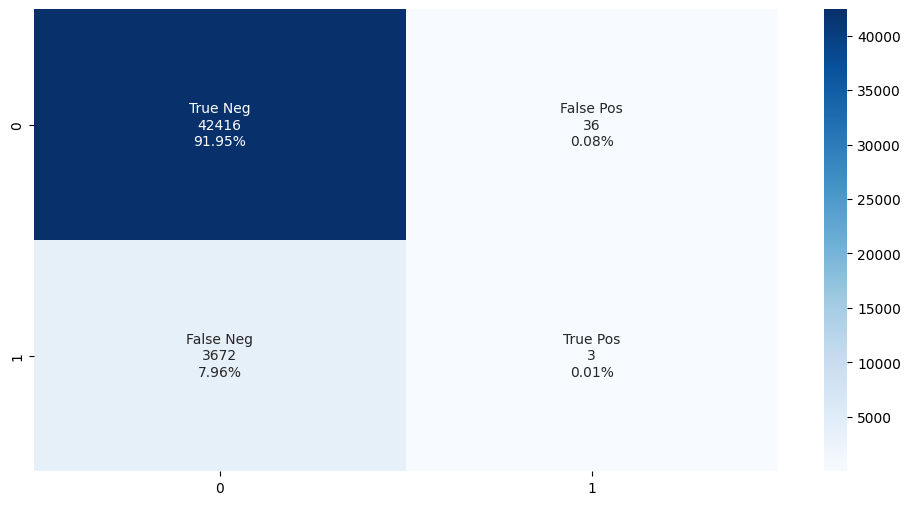

CPU times: total: 2min 10s
Wall time: 27.8 s


In [21]:
%%time

lr = LogisticRegression(random_state=0)
lr.fit(train_x, train_y)

metrics = calcul_metrics(lr, valid_x, valid_y)
print(classification_report(valid_y, lr.predict(valid_x)))

logToMLflow(lr, train_x, val_data, metrics, name="LogReg_noSmote_noParam", training_tag="Basic LR model no SMOTE no param")

displayConfMatrix(lr, valid_x, valid_y)

## Features Importances

### Native coef function

In [33]:
plt.figure(figsize=(12,6))
color_list =  sns.color_palette("dark", len(train_df.columns)) 
top_x = 10
logistic_reg_coeff = lr.coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(train_df.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

NameError: name 'lr' is not defined

### SHAP

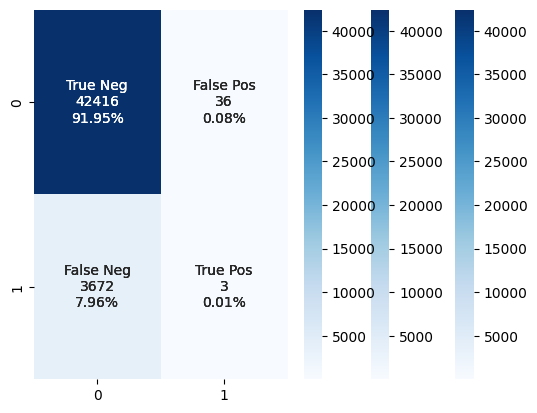

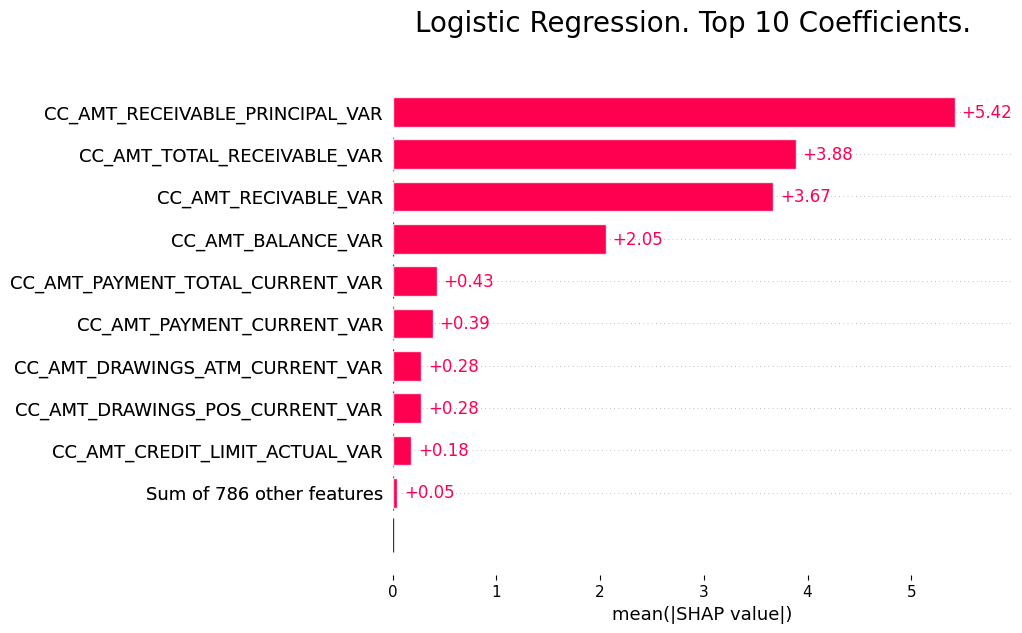

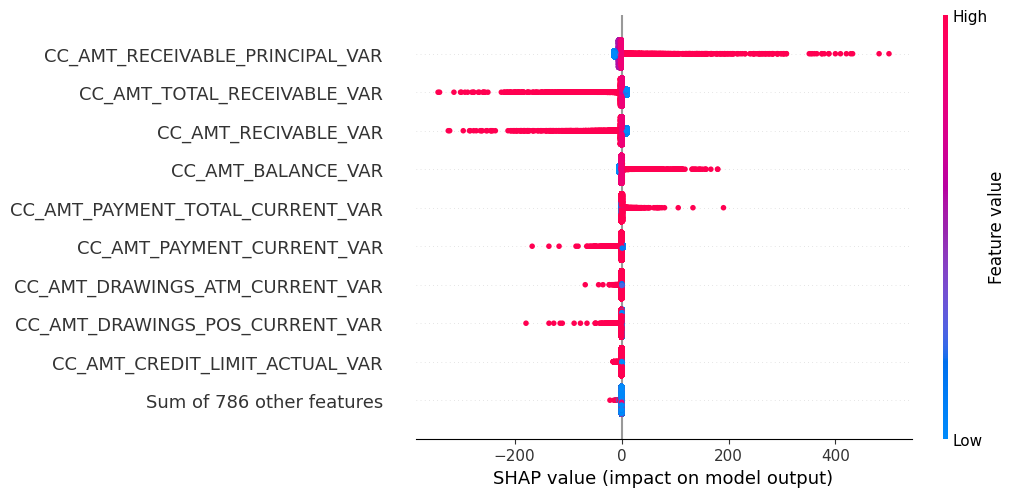

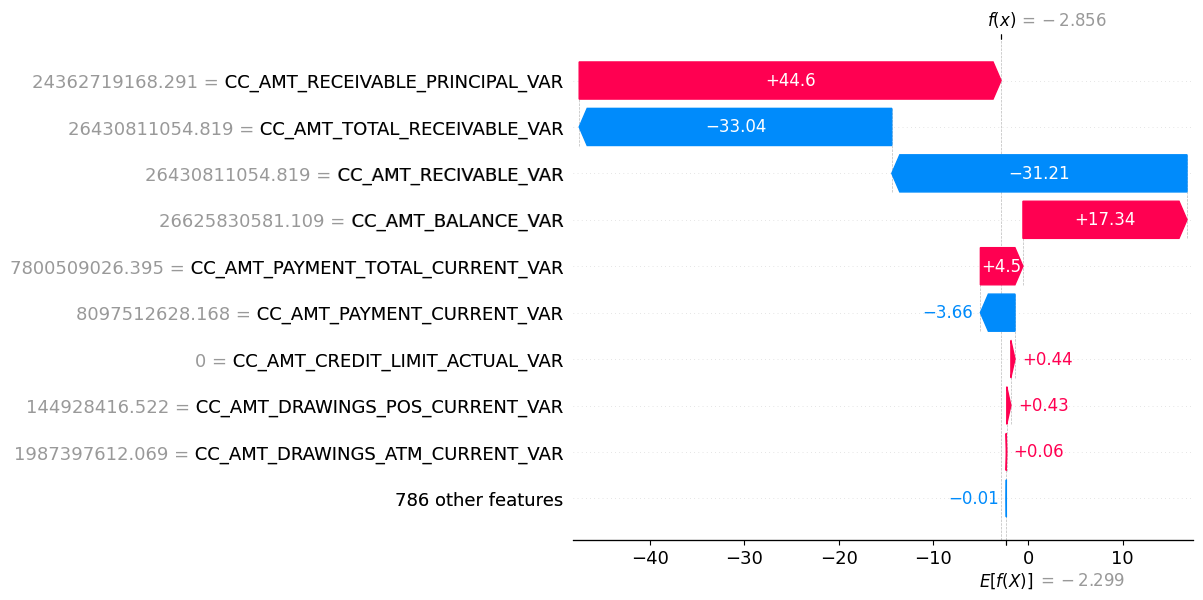

In [30]:
lin_explainer = shap.LinearExplainer(lr, train_x)

shap_values = lin_explainer(valid_x)

shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[50])

## With SMOTE

### No Param

Précision : 0.80
AUC : 0.54
Score métier : 0.7776356580744467
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.89     42452
         1.0       0.10      0.19      0.13      3675

    accuracy                           0.80     46127
   macro avg       0.51      0.52      0.51     46127
weighted avg       0.86      0.80      0.83     46127



2024/02/09 15:13:48 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/09 15:13:48 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/09 15:13:52 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/09 15:13:52 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

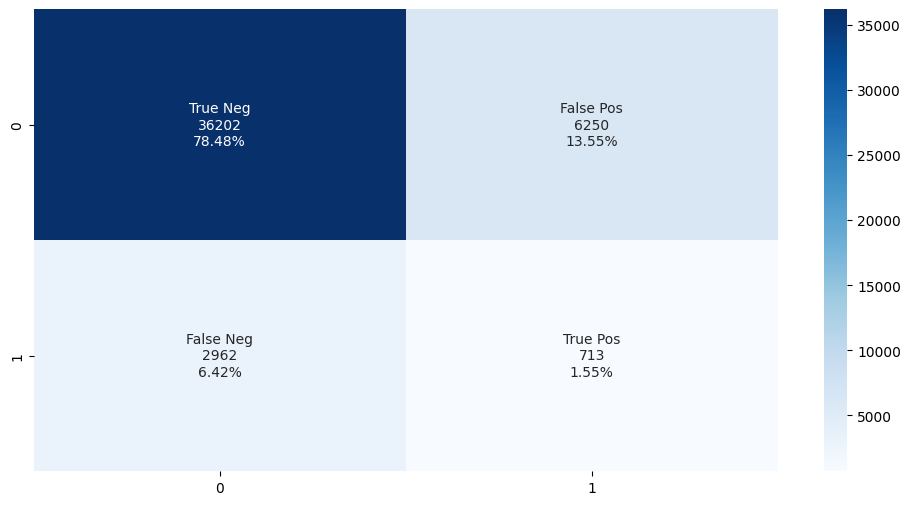

CPU times: total: 5min 9s
Wall time: 1min 6s


In [22]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)


metrics = calcul_metrics(pipeline, valid_x, valid_y)
print(classification_report(valid_y, pipeline.predict(valid_x)))

logToMLflow(pipeline, train_x, val_data, metrics, name="LogReg_Smote_noParam", training_tag="Basic LR model with SMOTE no param")

displayConfMatrix(pipeline, valid_x, valid_y)

### With GridSearchCV

In [24]:
%%time

params = {
    "model__C":np.logspace(-3, 3, 7)
}

steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_logreg = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer", n_jobs = -1)

GS_logreg.fit(train_x, train_y)

print("Best parameters :",GS_logreg.best_params_)
print("Score :",GS_logreg.best_score_)
resultizeGrid(GS_logreg)

Best parameters : {'model__C': 0.001}
Score : nan
CPU times: total: 4min 43s
Wall time: 23min 50s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
0,478.501130,450.093826,0.139401,0.278803,0.001,{'model__C': 0.001},NaN,NaN,1,NaN,NaN,1
1,473.135294,456.607408,0.077779,0.155559,0.01,{'model__C': 0.01},NaN,NaN,1,NaN,NaN,1
2,708.375223,430.759116,1.067198,1.615376,0.1,{'model__C': 0.1},NaN,NaN,1,NaN,NaN,1
3,268.741286,162.017971,0.000000,0.000000,1.0,{'model__C': 1.0},NaN,NaN,1,NaN,NaN,1
4,135.275424,60.734933,0.000000,0.000000,10.0,{'model__C': 10.0},NaN,NaN,1,NaN,NaN,1
5,423.065957,214.240600,0.673698,1.347396,100.0,{'model__C': 100.0},NaN,NaN,1,NaN,NaN,1
6,263.281474,213.629888,1.254853,1.555460,1000.0,{'model__C': 1000.0},NaN,NaN,1,NaN,NaN,1


Précision : 0.80
AUC : 0.54
Score métier : 0.7777657337351226
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.89     42452
         1.0       0.10      0.19      0.13      3675

    accuracy                           0.80     46127
   macro avg       0.51      0.52      0.51     46127
weighted avg       0.86      0.80      0.83     46127



2024/02/09 16:25:31 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/09 16:25:31 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/09 16:25:35 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/09 16:25:35 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

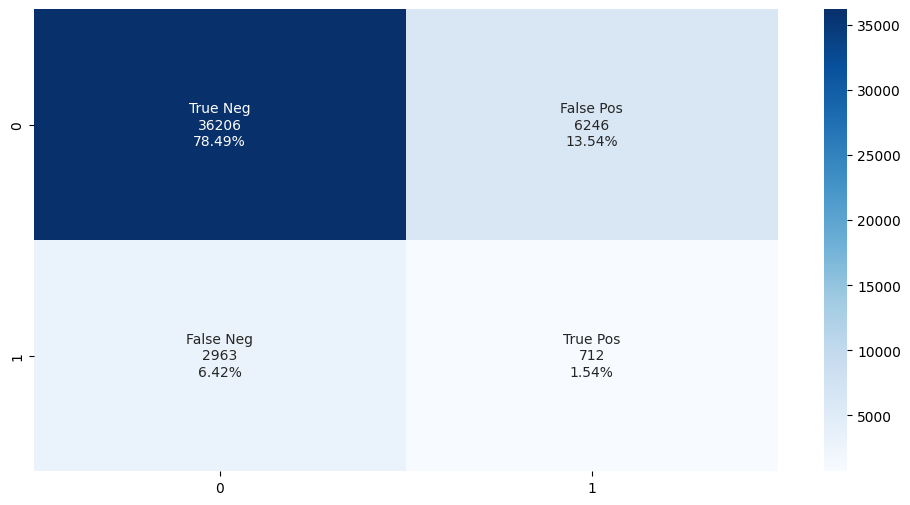

In [25]:
metrics = calcul_metrics(GS_logreg.best_estimator_, valid_x, valid_y)
print(classification_report(valid_y, GS_logreg.best_estimator_.predict(valid_x)))

logToMLflow(GS_logreg.best_estimator_, train_x, val_data, metrics, name="LogReg_Smote_GridSearch", params=GS_logreg.best_params_, training_tag="Basic LR model with SMOTE")
displayConfMatrix(GS_logreg.best_estimator_, valid_x, valid_y)

# RandomForest

## Baseline, paramètres par défaut

### Sans SMOTE

Précision : 0.92
AUC : 0.72
Score métier : 0.7950007587746872
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42452
         1.0       0.89      0.00      0.00      3675

    accuracy                           0.92     46127
   macro avg       0.90      0.50      0.48     46127
weighted avg       0.92      0.92      0.88     46127



2024/02/05 15:18:49 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/05 15:18:52 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/05 15:19:00 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
100%|===================| 3993/4000 [10:09<00:01]        2024/02/05 15:29:10 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ExplainerError('Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.770000, while the model output was 0.760000. If this difference is acceptable you can set check_additivity=False to disable this check.'). Set logging leve

<Figure size 1050x700 with 0 Axes>

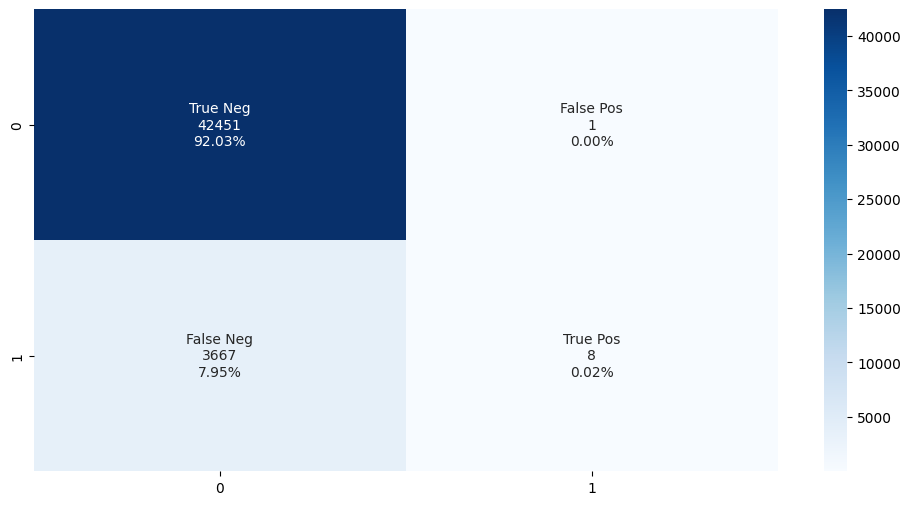

CPU times: total: 14min 55s
Wall time: 18min 48s


In [48]:
%%time

RFC_base = RandomForestClassifier(random_state=0)
RFC_base.fit(train_x, train_y)

metrics = calcul_metrics(RFC_base, valid_x, valid_y)
print(classification_report(valid_y, RFC_base.predict(valid_x)))

logToMLflow(RFC_base, train_x, val_data, metrics, name="RndForest_noSmote_noParam", training_tag="RandomForest model no SMOTE no param")
displayConfMatrix(RFC_base, valid_x, valid_y)

### Avec SMOTE

Précision : 0.58
AUC : 0.61
Score métier : 0.7378758644611616
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72     42452
         1.0       0.10      0.56      0.17      3675

    accuracy                           0.58     46127
   macro avg       0.52      0.57      0.45     46127
weighted avg       0.87      0.58      0.68     46127



2024/02/05 15:45:05 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/05 15:45:07 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/05 15:45:14 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/05 15:45:14 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

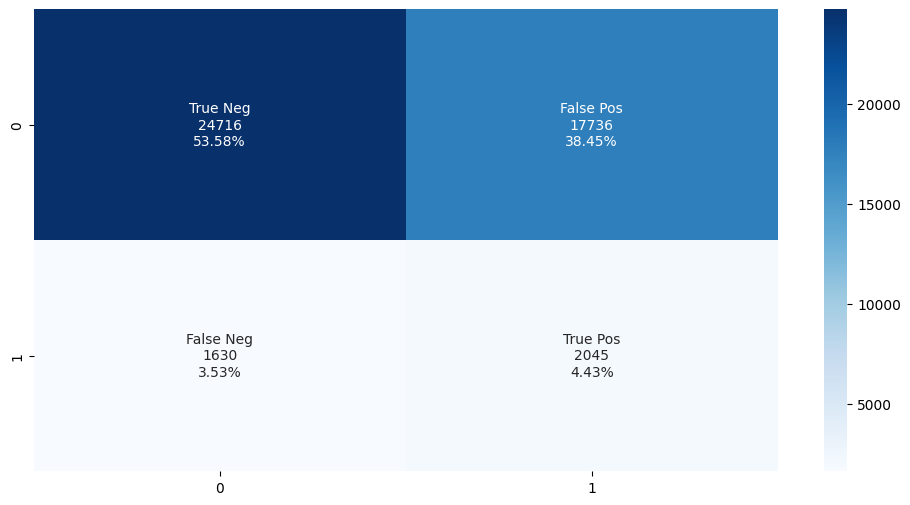

CPU times: total: 12min 9s
Wall time: 15min 6s


In [49]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)
print(classification_report(valid_y, pipeline.predict(valid_x)))

logToMLflow(pipeline, train_x, val_data, metrics, name="RndForest_WithSmote_noParam", training_tag="RandomForest model with SMOTE no param")
displayConfMatrix(pipeline, valid_x, valid_y)

## Recherche des meilleurs hyperparamètres

In [54]:
rftest = RandomForestClassifier()
print('Liste des paramètres de RandomForestClassifier :\n')
print(rftest.get_params())

Liste des paramètres de RandomForestClassifier :

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Utilisation de RandomizedSearchCV sur un nombre important de paramètres pour avoir une idée globale.

In [63]:
%%time

params = {
    'model__bootstrap': [True, False],
    'model__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10],
    'model__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
    
steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)

rf_random = RandomizedSearchCV(pipeline, params, n_iter = 100, scoring=scoring, refit="CustomScorer", cv = 3, random_state=0, n_jobs = -1)#"""estimator = """   """param_distributions = """
# Fit the random search model
rf_random.fit(train_x_10k, train_y_10k)

print("Best parameters :",rf_random.best_params_)
print("Score :",rf_random.best_score_)
resultizeGrid(rf_random)

tuned hyperparameters :(best parameters)  {'model__n_estimators': 600, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__bootstrap': True}
accuracy : -0.8165992064113429
CPU times: total: 1min 2s
Wall time: 1h 1min 53s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,param_model__bootstrap,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
49,95.684098,1.277924,0.706464,0.033683,600,2,sqrt,10,True,"{'model__n_estimators': 600, 'model__min_sampl...",0.711850,0.021174,17,-0.816599,0.009541,1
16,285.733666,1.999877,2.024920,0.399457,1200,1,sqrt,30,True,"{'model__n_estimators': 1200, 'model__min_samp...",0.710564,0.022846,27,-0.820100,0.002850,2
64,370.663151,3.110898,2.462478,0.019478,1600,1,sqrt,None,True,"{'model__n_estimators': 1600, 'model__min_samp...",0.710262,0.021824,29,-0.820100,0.002850,2
27,373.160966,1.392382,2.473115,0.164365,1600,1,sqrt,80,True,"{'model__n_estimators': 1600, 'model__min_samp...",0.710262,0.021824,29,-0.820100,0.002850,2
39,58.306726,1.330677,0.343327,0.059657,200,4,sqrt,80,False,"{'model__n_estimators': 200, 'model__min_sampl...",0.704633,0.022198,49,-0.820100,0.002850,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.373358,0.026176,0.000000,0.000000,2000,2,auto,40,False,"{'model__n_estimators': 2000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
36,0.396557,0.028497,0.000000,0.000000,1000,1,auto,10,False,"{'model__n_estimators': 1000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
69,0.430621,0.037382,0.000000,0.000000,2000,1,auto,30,False,"{'model__n_estimators': 2000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
56,0.369793,0.018900,0.000000,0.000000,800,4,auto,10,False,"{'model__n_estimators': 800, 'model__min_sampl...",NaN,NaN,53,NaN,NaN,53


Réduction des paramètres en fonction du résultat précédent. GridSearchCV pour trouver les paramètres finaux optimaux.

In [16]:
%%time

params = {
    'model__bootstrap': [True],
    'model__max_depth': [20, 40, 80],
    'model__max_features': ['sqrt'],
    'model__n_estimators': [600, 1000, 1400]
}

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_RF = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer", n_jobs = -1)

GS_RF.fit(train_x_10k, train_y_10k)

print("Best parameters :",GS_RF.best_params_)
print("Score :",GS_RF.best_score_)
resultizeGrid(GS_RF)

Best parameters : {'model__bootstrap': True, 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 600}
Score : -0.8211
CPU times: total: 1min 32s
Wall time: 21min 43s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__max_depth,param_model__max_features,param_model__n_estimators,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
0,168.694821,4.321191,0.690887,0.109089,True,20,sqrt,600,"{'model__bootstrap': True, 'model__max_depth':...",0.711553,0.026615,1,-0.8211,0.00196,1
1,283.027542,3.476307,1.221405,0.217730,True,20,sqrt,1000,"{'model__bootstrap': True, 'model__max_depth':...",0.710560,0.025711,3,-0.8211,0.00196,1
2,393.187593,3.772834,1.443657,0.138560,True,20,sqrt,1400,"{'model__bootstrap': True, 'model__max_depth':...",0.710802,0.026343,2,-0.8211,0.00196,1
3,174.806815,3.373968,0.676530,0.050402,True,40,sqrt,600,"{'model__bootstrap': True, 'model__max_depth':...",0.708721,0.026182,9,-0.8211,0.00196,1
4,293.806849,4.263216,1.023016,0.061124,True,40,sqrt,1000,"{'model__bootstrap': True, 'model__max_depth':...",0.709733,0.026927,5,-0.8211,0.00196,1
5,408.149371,11.917534,1.622157,0.144280,True,40,sqrt,1400,"{'model__bootstrap': True, 'model__max_depth':...",0.709206,0.027170,8,-0.8211,0.00196,1
6,175.246451,4.898930,0.620331,0.040535,True,80,sqrt,600,"{'model__bootstrap': True, 'model__max_depth':...",0.709285,0.026475,7,-0.8211,0.00196,1
7,287.251429,3.854050,0.943440,0.048573,True,80,sqrt,1000,"{'model__bootstrap': True, 'model__max_depth':...",0.709965,0.027247,4,-0.8211,0.00196,1
8,335.468185,15.607678,1.151228,0.076717,True,80,sqrt,1400,"{'model__bootstrap': True, 'model__max_depth':...",0.709546,0.027330,6,-0.8211,0.00196,1


Application des meilleurs paramètres :

Précision : 0.80
AUC : 0.64
Score métier : 0.6815097448349123
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89     42452
         1.0       0.15      0.33      0.21      3675

    accuracy                           0.80     46127
   macro avg       0.54      0.58      0.55     46127
weighted avg       0.87      0.80      0.83     46127



2024/02/06 13:36:27 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/06 13:36:32 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/06 13:36:43 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/06 13:36:43 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

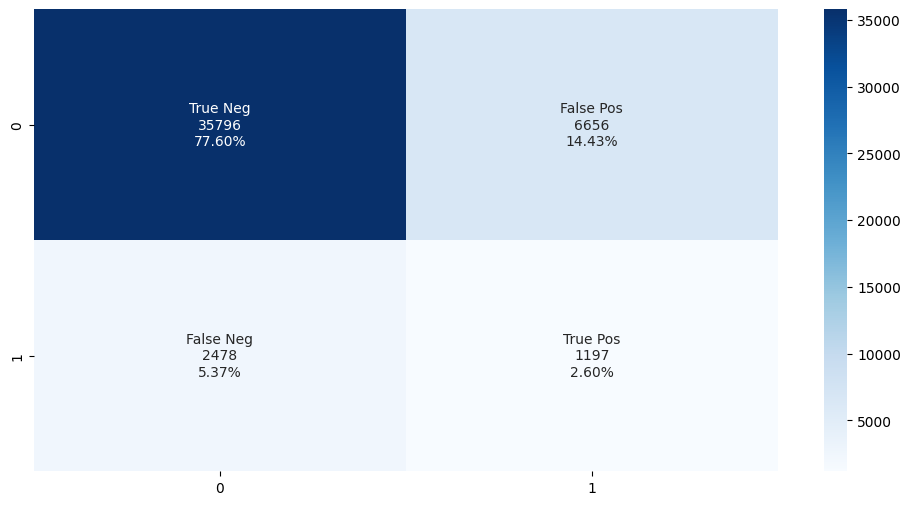

In [20]:
metrics = calcul_metrics(GS_RF.best_estimator_, valid_x, valid_y)
print(classification_report(valid_y, GS_RF.best_estimator_.predict(valid_x)))

logToMLflow(GS_RF.best_estimator_, train_x, val_data, metrics, name="RndForest_Smote_GridSearch", params=GS_RF.best_params_, training_tag="RandomForest model with SMOTE")
displayConfMatrix(GS_RF.best_estimator_, valid_x, valid_y)

In [20]:
%%time

params = {
    'model__bootstrap': [True],
    'model__max_depth': [3, 5],
    'model__max_features': ['sqrt'],
    'model__n_estimators': [600, 1000, 1400]
}

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_RF = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer", n_jobs = -1)

GS_RF.fit(train_x_10k, train_y_10k)

print("Best parameters :",GS_RF.best_params_)
print("Score :",GS_RF.best_score_)
resultizeGrid(GS_RF)

Best parameters : {'model__bootstrap': True, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__n_estimators': 1400}
Score : -0.7288
CPU times: total: 48.6 s
Wall time: 4min 54s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__max_depth,param_model__max_features,param_model__n_estimators,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
2,85.890151,1.813366,0.516973,0.028772,True,3,sqrt,1400,"{'model__bootstrap': True, 'model__max_depth':...",0.670642,0.028648,6,-0.7288,0.028227,1
0,37.769068,1.015206,0.263267,0.032328,True,3,sqrt,600,"{'model__bootstrap': True, 'model__max_depth':...",0.671463,0.028270,4,-0.7289,0.028237,2
1,61.766412,2.163569,0.387354,0.019968,True,3,sqrt,1000,"{'model__bootstrap': True, 'model__max_depth':...",0.670710,0.027651,5,-0.7320,0.029247,3
5,109.177492,3.570143,0.411350,0.021315,True,5,sqrt,1400,"{'model__bootstrap': True, 'model__max_depth':...",0.686182,0.027778,3,-0.7512,0.013257,4
4,94.178683,3.602191,0.380404,0.036171,True,5,sqrt,1000,"{'model__bootstrap': True, 'model__max_depth':...",0.686761,0.027077,2,-0.7536,0.017330,5
3,59.605567,1.319421,0.273131,0.013261,True,5,sqrt,600,"{'model__bootstrap': True, 'model__max_depth':...",0.687838,0.027205,1,-0.7573,0.015689,6


Précision : 0.72
AUC : 0.64
Score métier : 0.6704749929542351
              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83     42452
         1.0       0.13      0.46      0.21      3675

    accuracy                           0.72     46127
   macro avg       0.54      0.60      0.52     46127
weighted avg       0.88      0.72      0.78     46127



2024/02/07 14:30:37 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/07 14:30:40 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/07 14:30:48 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/07 14:30:48 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

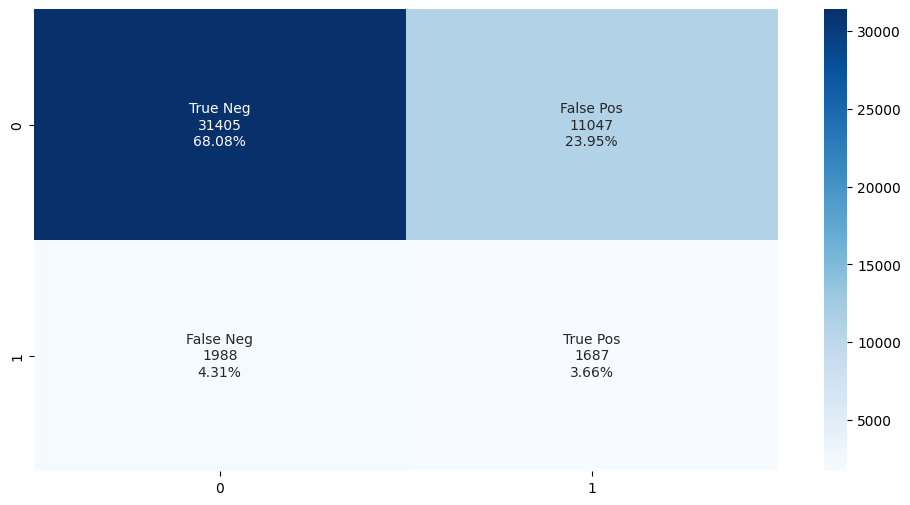

In [30]:
metrics = calcul_metrics(GS_RF.best_estimator_, valid_x, valid_y)
print(classification_report(valid_y, GS_RF.best_estimator_.predict(valid_x)))

logToMLflow(GS_RF.best_estimator_, train_x, val_data, metrics, name="RndForest_Smote_GridSearch", params=GS_RF.best_params_, training_tag="RandomForest model with SMOTE")
displayConfMatrix(GS_RF.best_estimator_, valid_x, valid_y)

In [37]:
shap_values.shape

(46127, 795, 2)

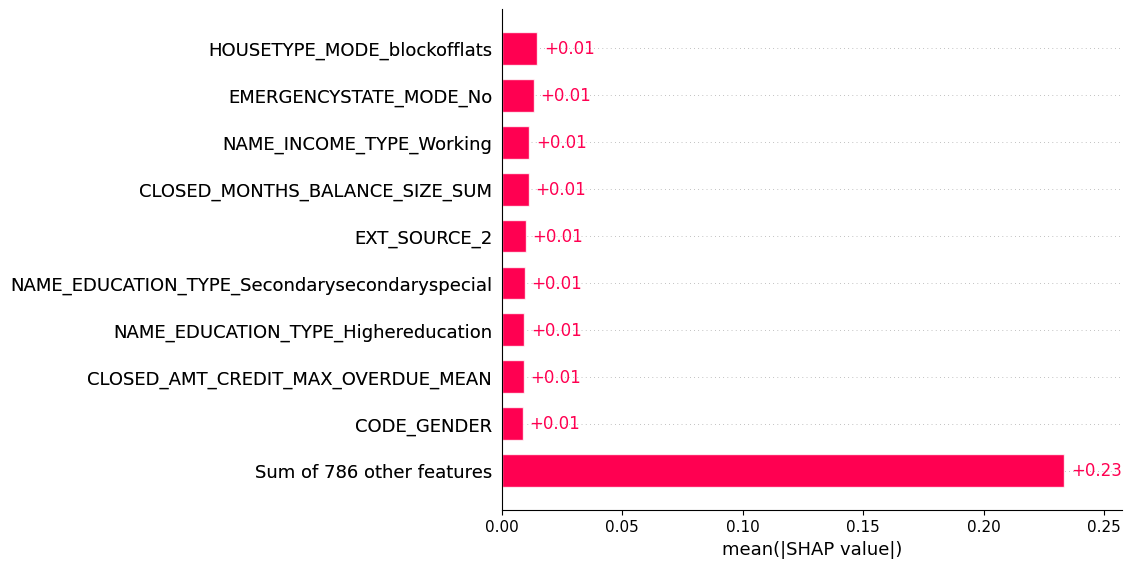

In [40]:
shap.plots.bar(shap_values[:,:,1])

In [32]:
tree_explainer = shap.TreeExplainer(GS_RF.best_estimator_[1], train_x_10k)

shap_values = tree_explainer(valid_x, check_additivity=False)

shap.plots.bar(shap_values[:,:,1])
shap.plots.waterfall(shap_values[50])

100%|===================| 92252/92254 [28:52<00:00]        

IndexError: list index out of range

# LIGHTGBM

## Pramètres par défaut

### Sans SMOTE

[LightGBM] [Info] Number of positive: 21150, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.492544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98919
[LightGBM] [Info] Number of data points in the train set: 261380, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080917 -> initscore=-2.429957
[LightGBM] [Info] Start training from score -2.429957
Précision : 0.92
AUC : 0.79
Score métier : 0.7767251284497149
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42452
         1.0       0.53      0.03      0.05      3675

    accuracy                           0.92     46127
   macro avg       0.73      0.51      0.51     46127
weighted avg       0.89      0.92      0.89     46127



2024/02/08 14:28:17 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/08 14:28:17 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/08 14:28:21 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
2024/02/08 14:28:27 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'TreeEnsemble' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.


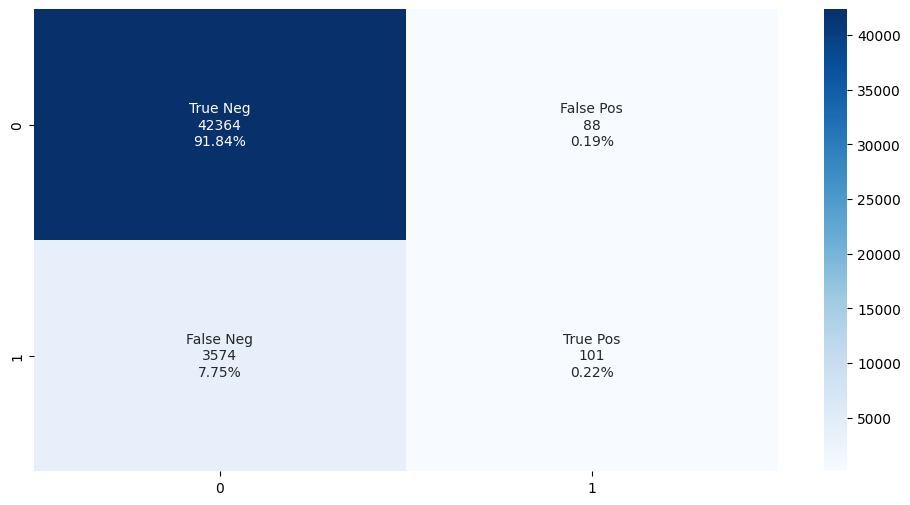

CPU times: total: 1min 11s
Wall time: 33.6 s


In [17]:
%%time

LGBM_base = LGBMClassifier(random_state=0)
LGBM_base.fit(train_x, train_y)

metrics = calcul_metrics(LGBM_base, valid_x, valid_y)
print(classification_report(valid_y, LGBM_base.predict(valid_x)))

logToMLflow(LGBM_base, train_x, val_data, metrics, name="LGBM_noSmote_noParam", training_tag="LGBM model no SMOTE no param")
displayConfMatrix(LGBM_base, valid_x, valid_y)

### Avec SMOTE

[LightGBM] [Info] Number of positive: 240230, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.665506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181351
[LightGBM] [Info] Number of data points in the train set: 480460, number of used features: 764
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Précision : 0.87
AUC : 0.74
Score métier : 0.6578142953151083
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     42452
         1.0       0.23      0.26      0.24      3675

    accuracy                           0.87     46127
   macro avg       0.58      0.59      0.59     46127
weighted avg       0.88      0.87      0.88     46127



2024/02/08 12:09:59 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/08 12:09:59 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/08 12:10:03 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/08 12:10:03 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

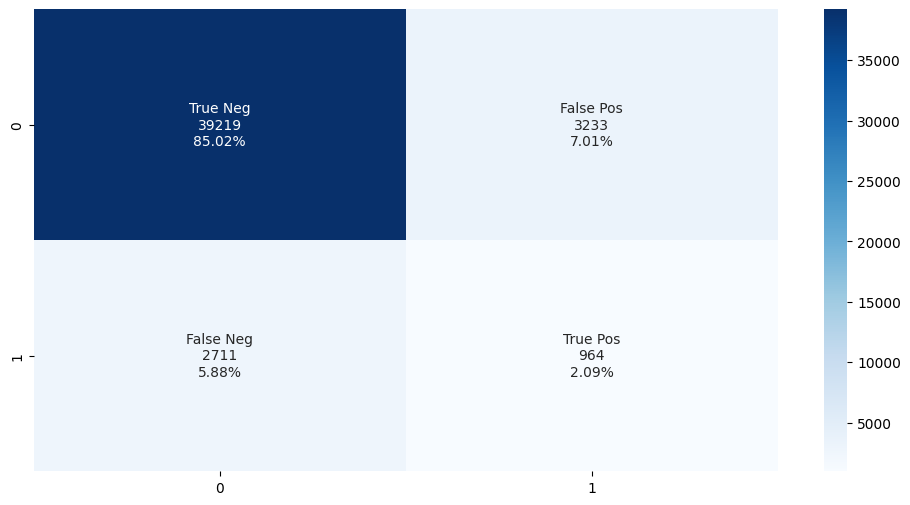

CPU times: total: 2min 21s
Wall time: 1min 5s


In [17]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)
print(classification_report(valid_y, pipeline.predict(valid_x)))

logToMLflow(pipeline, train_x, val_data, metrics, name="LGBM_WithSmote_noParam", training_tag="LGBM model with SMOTE no param")
displayConfMatrix(pipeline, valid_x, valid_y)

## Recherche des meilleurs hyperparamètres

In [30]:
lgbmtest = LGBMClassifier()
print('Liste des paramètres de LGBMClassifier :\n')
print(lgbmtest.get_params())

Liste des paramètres de LGBMClassifier :

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [18]:
%%time

params = {
    'model__num_leaves': [10, 20, 30, 40, 50, 60, 100],
    'model__max_depth': [5, 7, 10, 15, -1],
    'model__learning_rate ': [0.01, 0.05, 0.1, 0.2, 0.5],
    'model__n_estimators': [100, 400, 700, 1000, 1600]
}
    
steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)

lgbm_random = RandomizedSearchCV(pipeline, params, n_iter = 100, scoring=scoring, refit="CustomScorer", cv = 3, random_state=0, n_jobs = -1)
# Fit the random search model
lgbm_random.fit(train_x_10k, train_y_10k)

print("Best parameters :",lgbm_random.best_params_)
print("Score :",lgbm_random.best_score_)
resultizeGrid(lgbm_random)

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 9179, number of negative: 9179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156088
[LightGBM] [Info] Number of data points in the train set: 18358, number of used features: 742
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters : {'m

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__num_leaves,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
48,56.820068,0.588410,0.105390,0.002717,10,700,5,0.01,"{'model__num_leaves': 10, 'model__n_estimators...",0.722366,0.005765,56,-0.790399,0.009186,1
66,44.394897,0.508127,0.107130,0.004893,10,400,10,0.05,"{'model__num_leaves': 10, 'model__n_estimators...",0.724382,0.012709,50,-0.794499,0.008256,2
65,44.219483,1.641013,0.095255,0.002717,10,400,10,0.01,"{'model__num_leaves': 10, 'model__n_estimators...",0.724382,0.012709,50,-0.794499,0.008256,2
85,35.550701,0.175703,0.096934,0.002110,10,400,5,0.2,"{'model__num_leaves': 10, 'model__n_estimators...",0.725119,0.005437,48,-0.794899,0.007009,4
79,132.918029,3.363098,0.206033,0.038769,10,1600,5,0.1,"{'model__num_leaves': 10, 'model__n_estimators...",0.712420,0.006184,88,-0.794900,0.003418,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,261.740019,18.574169,0.193084,0.015219,100,1000,10,0.1,"{'model__num_leaves': 100, 'model__n_estimator...",0.733582,0.003785,21,-0.813399,0.008203,94
61,211.694886,4.134067,0.195459,0.026987,40,700,10,0.05,"{'model__num_leaves': 40, 'model__n_estimators...",0.726065,0.001756,46,-0.813599,0.004889,97
60,84.110665,1.872692,0.091375,0.003685,100,100,-1,0.2,"{'model__num_leaves': 100, 'model__n_estimator...",0.740164,0.005050,13,-0.814200,0.007490,98
89,249.268647,3.585857,0.155313,0.004842,100,700,-1,0.2,"{'model__num_leaves': 100, 'model__n_estimator...",0.733870,0.002092,20,-0.814400,0.005288,99


In [20]:
%%time

params = {
    'model__num_leaves': [5, 10, 20],
    'model__max_depth': [3, 5, 10, -1],
    'model__learning_rate ': [0.02, 0.05, 0.1],
    'model__n_estimators': [400, 700]
}

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_LGBM = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer", n_jobs = -1)

GS_LGBM.fit(train_x_10k, train_y_10k)

print("Best parameters :",GS_LGBM.best_params_)
print("Score :",GS_LGBM.best_score_)
resultizeGrid(GS_LGBM)

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02
[LightGBM] [Info] Number of positive: 9179, number of negative: 9179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156088
[LightGBM] [Info] Number of data points in the train set: 18358, number of used features: 742
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters : {'model__learning_rate ': 0.02, 'model__max_depth': 5, 'model__n_estimators': 700, 'model__num_leaves': 5}
Score : -0.7844
CPU times: total: 21.3 s
Wall time: 32min 36s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__num_leaves,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
63,52.996534,2.363780,0.076325,0.005000,0.1,10,700,5,"{'model__learning_rate ': 0.1, 'model__max_dep...",0.734831,0.022043,22,-0.7844,0.009754,1
15,42.262551,0.496062,0.077022,0.008652,0.02,10,700,5,"{'model__learning_rate ': 0.02, 'model__max_de...",0.734831,0.022043,22,-0.7844,0.009754,1
69,44.173114,0.724321,0.073879,0.005834,0.1,-1,700,5,"{'model__learning_rate ': 0.1, 'model__max_dep...",0.734831,0.022043,22,-0.7844,0.009754,1
9,42.579863,1.860782,0.075941,0.010354,0.02,5,700,5,"{'model__learning_rate ': 0.02, 'model__max_de...",0.734831,0.022043,22,-0.7844,0.009754,1
33,43.356386,2.626765,0.075989,0.010706,0.05,5,700,5,"{'model__learning_rate ': 0.05, 'model__max_de...",0.734831,0.022043,22,-0.7844,0.009754,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,166.069877,1.633796,0.116572,0.026026,0.02,-1,700,20,"{'model__learning_rate ': 0.02, 'model__max_de...",0.729205,0.018378,52,-0.8031,0.007372,67
71,80.146889,6.219716,0.073713,0.010563,0.1,-1,700,20,"{'model__learning_rate ': 0.1, 'model__max_dep...",0.729205,0.018378,52,-0.8031,0.007372,67
41,145.808438,1.745034,0.096205,0.010244,0.05,10,700,20,"{'model__learning_rate ': 0.05, 'model__max_de...",0.722136,0.022329,70,-0.8034,0.011578,70
65,166.321678,9.191988,0.090834,0.002916,0.1,10,700,20,"{'model__learning_rate ': 0.1, 'model__max_dep...",0.722136,0.022329,70,-0.8034,0.011578,70


[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02
Précision : 0.88
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02
AUC : 0.73
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02
Score métier : 0.6878400936544757
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     42452
         1.0       0.23      0.20      0.22      3675

    accuracy                           0.88     46127
   macro avg       0.58      0.57      0.58     46127
weighted avg       0.88      0.88     

2024/02/08 16:48:27 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/08 16:48:27 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.


[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02


2024/02/08 16:48:31 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/08 16:48:31 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.02


<Figure size 1050x700 with 0 Axes>

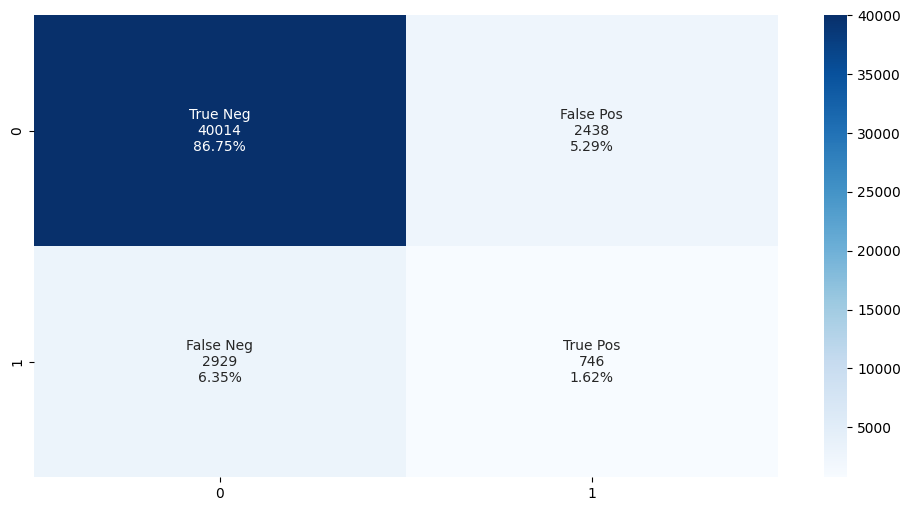

In [21]:
metrics = calcul_metrics(GS_LGBM.best_estimator_, valid_x, valid_y)
print(classification_report(valid_y, GS_LGBM.best_estimator_.predict(valid_x)))

logToMLflow(GS_LGBM.best_estimator_, train_x, val_data, metrics, name="LGBM_Smote_GridSearch", params=GS_LGBM.best_params_, training_tag="LightGBM model with SMOTE")
displayConfMatrix(GS_LGBM.best_estimator_, valid_x, valid_y)

100%|===================| 46075/46127 [09:55<00:00]        

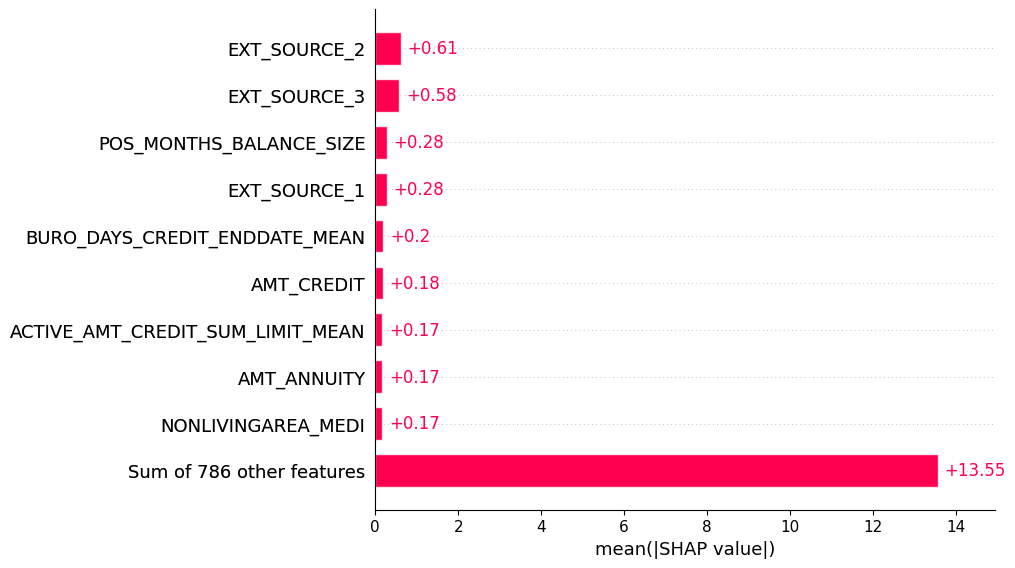

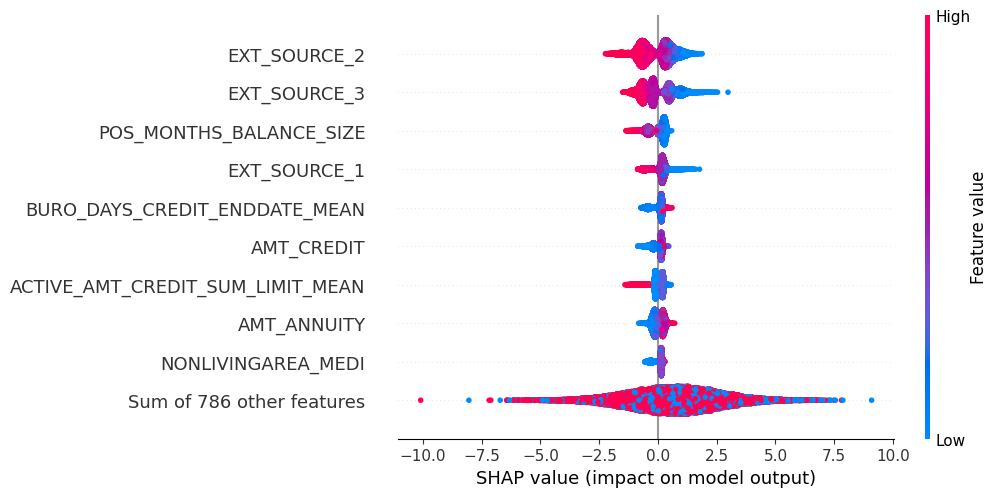

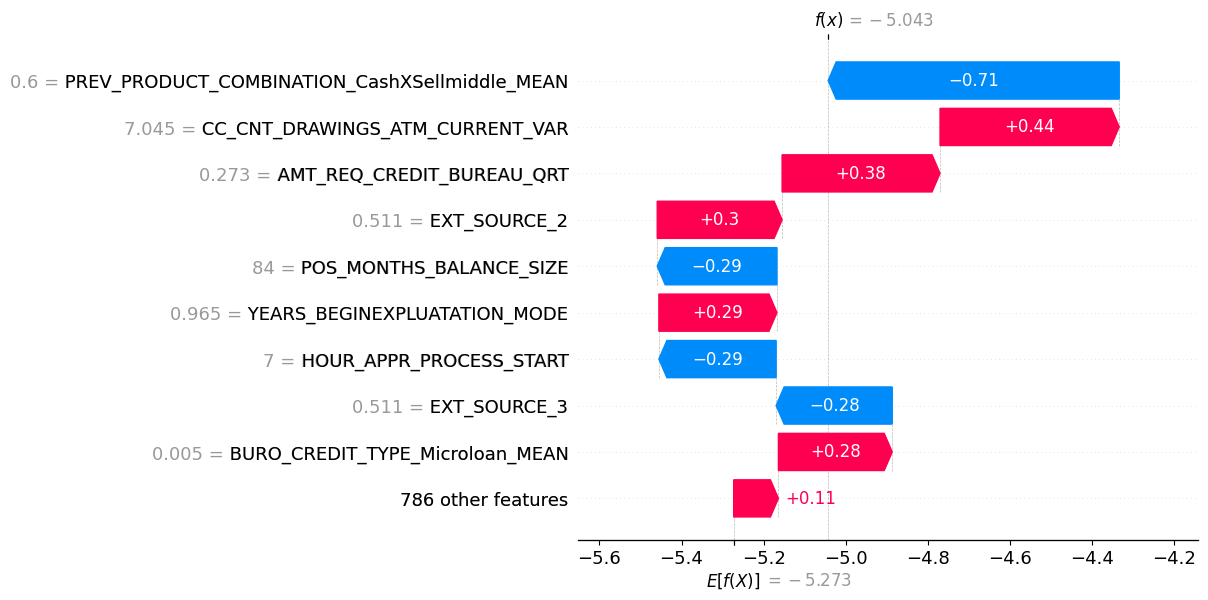

In [40]:
tree_explainer = shap.TreeExplainer(GS_LGBM.best_estimator_[1], train_x_10k)

shap_values = tree_explainer(valid_x, check_additivity=False)

shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[50])

# Test avec LGBM paramètres de Kaggle

In [17]:
%%time


clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

clf.fit(train_x, train_y)

CPU times: total: 37min 34s
Wall time: 10min 49s


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

Précision : 0.92
AUC : 0.78
Score métier : 0.7525960933943243
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42452
         1.0       0.55      0.06      0.11      3675

    accuracy                           0.92     46127
   macro avg       0.73      0.53      0.53     46127
weighted avg       0.89      0.92      0.89     46127



2024/02/09 14:35:52 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/09 14:35:59 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/09 14:36:31 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
100%|===================| 1997/2000 [09:29<00:00]        2024/02/09 14:46:01 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ExplainerError('Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -2.241252, while the model output was -2.347699. If this difference is acceptable you can set check_additivity=False to disable this check.'). Set logging le

<Figure size 1050x700 with 0 Axes>

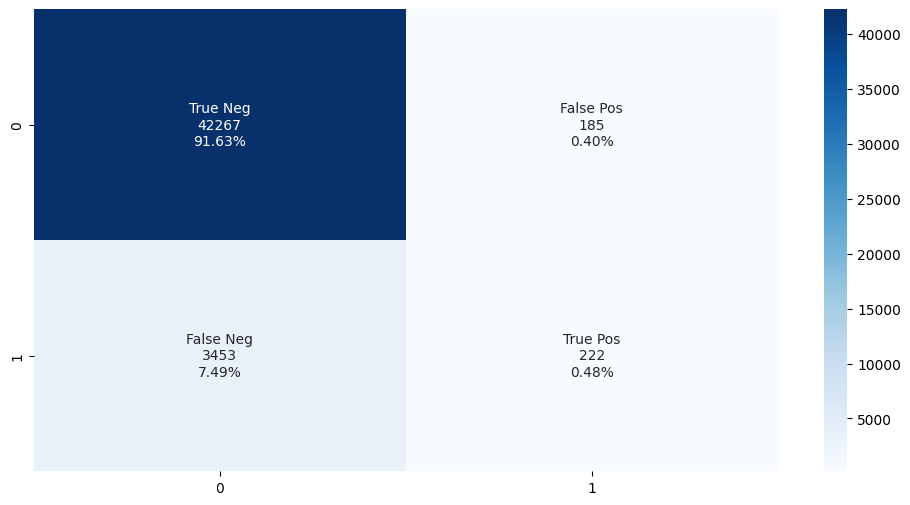

In [20]:
metrics = calcul_metrics(clf, valid_x, valid_y)
print(classification_report(valid_y, clf.predict(valid_x)))

logToMLflow(clf, train_x, val_data, metrics, name="LGBM_BestFromKaggle", params=clf.get_params(), training_tag="LightGBM model from Kaggle")
displayConfMatrix(clf, valid_x, valid_y)

# Meilleur modèle : Optimisation du threshold

In [22]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

probs = pipeline.predict_proba(valid_x)

for threshold in np.arange(0, 1, 0.05):
    preds = (probs[:,1] >= threshold).astype(int)
    score_metier = custom_score_func(valid_y, preds)
    print(f'Threshold : {threshold}, Score métier : {score_metier}')

[LightGBM] [Info] Number of positive: 240230, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.735619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181351
[LightGBM] [Info] Number of data points in the train set: 480460, number of used features: 764
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Threshold : 0.0, Score métier : 0.9203286578359746
Threshold : 0.05, Score métier : 0.7823617404123399
Threshold : 0.1, Score métier : 0.6353762438485052
Threshold : 0.15000000000000002, Score métier : 0.5736770221345416
Threshold : 0.2, Score métier : 0.5558132980683764
Threshold : 0.25, Score métier : 0.5576777158713986
Threshold : 0.30000000000000004, Score métier : 0.5675201075292128
Threshold : 0.35000000000000003, Score métier : 0.5919960110130726
Threshold : 0.4, Score métier : 0.611333925900232
Threshold : 0.45, Score métier : 0.634682506991